In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp
#import cgl_thalamic as ct
import cgl1 as c1
from cgl_thalamic import rhs_cgl

from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import solve_ivp

In [2]:
reload(c1);reload(nm);reload(rp)
nmc = nm.nmCoupling;rsp = rp.Response

# CGL 1

In [3]:
pd1 = {'q':1,'d':.9,'sig':.1,'rho':.15,'mu':.15,
       'om':1,'om_fix':1,'alc':3,'bec':2,'esyn':0}

system1 = rsp(var_names=['x','y','w'],
              pardict=pd1,rhs=rhs_cgl,
              init=np.array([.333,0,0,2*np.pi]),
              TN=2000,
              idx=0,
              model_name='cglf0',
              trunc_order=5,
              
              recompute_list=[],
              z_forward=False,
              i_forward=False,
              i_bad_dx=False,
              coupling=c1.coupling_cgl)

* Loading LC data...
* Loading monodromy...
* Floquet Exponent kappa =-0.02999999999993149
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [132]:
def ff(x,a,om,del1=0):
    return a*np.sin((om+del1)*x)+.2

In [5]:
# default period must be 2*np.pi
pd2 = {'om':1,'amp':1,'om_fix':1}

system2 = rsp(var_names=[],
              pardict=pd2,rhs=None,init=None,
              coupling=None,
              model_name='f1',
              forcing_fn=ff,
              idx=1,
              TN=0)

In [6]:
a = nmc(system1,system2,
        #recompute_list=['p_cglf0','h_cglf0','p_data_cglf0','h_data_cglf0'],
        #recompute_list=recompute_list,
        _n=('om0',1),_m=('om1',2),
        NP=210,NH=100)

* Loading p symbolic...
* Loading p...
* Loading p...
* Loading p...
* Loading p...
* Loading p...
* Loading p...
* Loading H symbolic...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...
* Loading H cglf0, order=2...
* Loading H cglf0, order=3...
* Loading H cglf0, order=4...
* Loading H cglf0, order=5...


In [7]:
print(system1.K['sym'])
print(system1.p['sym'])
print(system1.h['sym'])

{'x0': [-f1*om0*om_fix0, 0, 0, 0, 0, 0], 'y0': [0, 0, 0, 0, 0, 0], 'w0': [0, 0, 0, 0, 0, 0]}
{0: 0, 1: -f1*om0*om_fix0*i_cglf0_x0[0], 2: -f1*om0*om_fix0*i_cglf0_x0[1]*p_cglf0[1], 3: -f1*om0*om_fix0*i_cglf0_x0[1]*p_cglf0[2] - f1*om0*om_fix0*i_cglf0_x0[2]*p_cglf0[1]**2, 4: -f1*om0*om_fix0*i_cglf0_x0[1]*p_cglf0[3] - 2*f1*om0*om_fix0*i_cglf0_x0[2]*p_cglf0[1]*p_cglf0[2] - f1*om0*om_fix0*i_cglf0_x0[3]*p_cglf0[1]**3, 5: -f1*om0*om_fix0*i_cglf0_x0[1]*p_cglf0[4] - 2*f1*om0*om_fix0*i_cglf0_x0[2]*p_cglf0[1]*p_cglf0[3] - f1*om0*om_fix0*i_cglf0_x0[2]*p_cglf0[2]**2 - 3*f1*om0*om_fix0*i_cglf0_x0[3]*p_cglf0[1]**2*p_cglf0[2] - f1*om0*om_fix0*i_cglf0_x0[4]*p_cglf0[1]**4}
{0: -f1*om0*om_fix0*z_cglf0_x0[0], 1: -f1*om0*om_fix0*p_cglf0[1]*z_cglf0_x0[1], 2: -f1*om0*om_fix0*p_cglf0[1]**2*z_cglf0_x0[2] - f1*om0*om_fix0*p_cglf0[2]*z_cglf0_x0[1], 3: -f1*om0*om_fix0*p_cglf0[1]**3*z_cglf0_x0[3] - 2*f1*om0*om_fix0*p_cglf0[1]*p_cglf0[2]*z_cglf0_x0[2] - f1*om0*om_fix0*p_cglf0[3]*z_cglf0_x0[1], 4: -f1*om0*om_fix0*p_cg

## Reduced rhs

In [8]:
def ct_redu(t,y,eps,system1,del1):
    h = 0
    for i in range(system1.miter):
        h += eps**(i+1)*(system1.h['lam'][i](y))
    h += del1
    return h

In [9]:
system1.h['lam']

{0: <lib.interp_basic.interp_basic at 0x7fd323760c70>,
 1: <lib.interp_basic.interp_basic at 0x7fd322a3a4c0>,
 2: <lib.interp_basic.interp_basic at 0x7fd323da42b0>,
 3: <lib.interp_basic.interp_basic at 0x7fd3266de9a0>,
 4: <lib.interp_basic.interp_basic at 0x7fd323460820>,
 5: <lib.interp_basic.interp_basic at 0x7fd323c6aa00>}

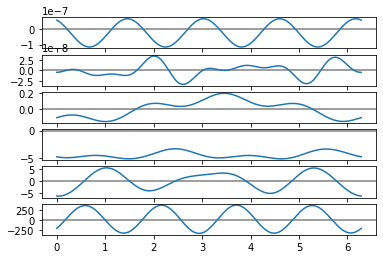

In [10]:
fig,axs = plt.subplots(system1.miter,1)

x = np.linspace(0,2*np.pi,200)
for i in range(system1.miter):
    axs[i].axhline(0,0,2*np.pi*a._m[1],color='gray')
    axs[i].plot(x,system1.h['lam'][i](x))

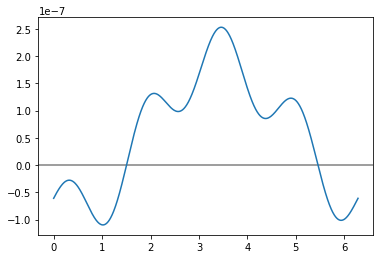

In [131]:
eps = .01
del1 = 1e-7
x = np.linspace(0,2*np.pi,1000)
h = ct_redu(0,x,eps,system1,del1)

fig,axs = plt.subplots()
axs.axhline(0,0,2*np.pi,color='gray')
axs.plot(x,h)

## Full rhs

In [21]:
def ct_full(t,y,eps,pd1,pd2,del1):
    out1 = rhs_cgl(t,y,pd1,'val',0) + eps*c1.coupling_cgl([*y,system2(t,del1)],pd2,'val',1)
    return np.array(list(out1))

# Integrate full and reduced

In [41]:
th_init = 5

In [42]:
eps_val = .1
del_val = .00001
pd1 = system1.pardict;pd2 = system2.pardict
pd1['om0'] = a._n[1];pd2['om1'] = a._m[1]

dt = .02;T=10000
t = np.arange(0,T,dt)
sol_redu = solve_ivp(ct_redu,[0,t[-1]],[th_init],method='LSODA',t_eval=t,
                     args=(eps_val,system1,del_val),rtol=1e-7,atol=1e-7)

In [43]:
sol_full = solve_ivp(ct_full,[0,t[-1]],[.4*np.cos(th_init),.4*np.sin(th_init),0],method='LSODA',
                     t_eval=t,args=(eps_val,pd1,pd2,del_val),rtol=1e-7,atol=1e-7)

(9899.98, 9999.98)

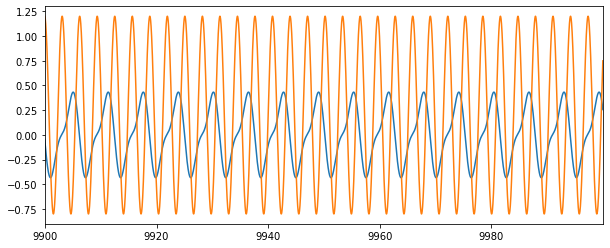

In [44]:
fig,axs = plt.subplots(figsize=(10,4))
axs.plot(sol_full.t,sol_full.y.T[:,0])
axs.plot(sol_full.t,system2(sol_full.t))
axs.set_xlim(t[-1]-100,t[-1])
#axs.set_xlim(0,100)

## Full model phase estimate

In [45]:
def get_phase(sol_full,skipn):

    phase1 = np.zeros(len(sol_full.t[::skipn]))
    for i in range(len(sol_full.t[::skipn])):
        d1 = np.linalg.norm(sol_full.y.T[::skipn][i,:3]-system1.lc['dat'],axis=1)
        phase1[i] = np.argmin(d1)/len(system1.lc['dat'])
    return sol_full.t[::skipn],phase1

In [46]:
# estimate phase for each model and compare phase difference
skipn = 10
x, phase1 = get_phase(sol_full,10)

# Full vs phase

(0.0, 6.283185307179586)

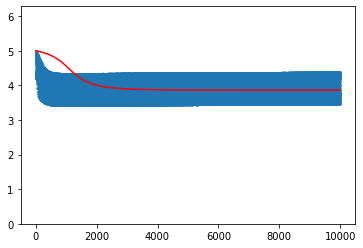

In [47]:
fig,axs = plt.subplots()
forcing_phase = np.mod(a._m[1]*np.linspace(0,x[-1],len(x)),2*np.pi*a._m[1])
y = np.mod(phase1*2*np.pi-a.om*forcing_phase,2*np.pi)
#y = phase1*2*np.pi

axs.scatter(x,y,s=1)
#axs.plot(x,np.mod(forcing_phase,2*np.pi))
axs.plot(t,np.mod(sol_redu.y.T[:,0],2*np.pi),color='red')
#axs.set_xlim(0,100)
axs.set_ylim(0,2*np.pi)

## Bifurcations in coupling strength

In [59]:
eps_list = np.linspace(0,.1,200)
x = np.linspace(0,2*np.pi,10000)
h = 0

zu = []
zs = []

for eps_val in eps_list:
    h = ct_redu(0,x,eps_val,system1,del_val)
    #for i in range(system1.miter):
    #    h += eps_val**(i+1)*(system1.h['lam'][i](x))
    # get all zeros
    
    z1 = x[1:][(h[1:]>0)*(h[:-1]<=0)]
    z2 = x[1:][(h[1:]<0)*(h[:-1]>=0)]
    zu.append(z1)
    zs.append(z2)

(0.0, 0.1)

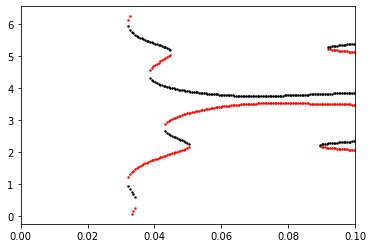

In [61]:
fig,axs=plt.subplots()

for xe, ye in zip(eps_list, zu):
    axs.scatter([xe] * len(ye), ye,s=2,c='red')

for xe, ye in zip(eps_list, zs):
    axs.scatter([xe] * len(ye), ye,s=2,c='k')

axs.set_xlim(0,eps_list[-1])

## Range of initial conditions

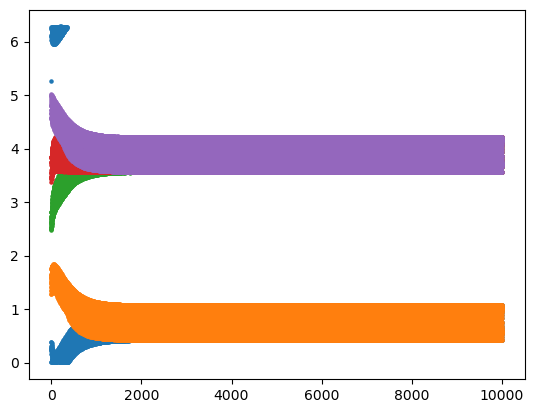

In [48]:
thlist = np.linspace(0,2*np.pi,5,endpoint=False)
epsval2 = .075

dt2 = .02;T2=10000
t2 = np.arange(0,T2,dt2)



fig,axs = plt.subplots()
for th_val in thlist:
    sol_full = solve_ivp(ct_full,[0,t2[-1]],[.4*np.cos(th_val),
                                            .4*np.sin(th_val),0],
                         method='LSODA',t_eval=t2,args=(epsval2,pd1,pd2),
                         rtol=1e-6,atol=1e-6)
    x2,phases = get_phase(sol_full,20)

    forcing_phase2 = np.mod(a._m[1]*np.linspace(0,x2[-1],len(x2)),2*np.pi*a._m[1])
    #y2 = np.mod(phases*2*np.pi-a.om*forcing_phase2,2*np.pi)
    #axs.plot(x2,forcing_phase2);axs.plot(x2,phases*2*np.pi)
    axs.scatter(x2,np.mod(phases*2*np.pi-a.om*forcing_phase2,2*np.pi),s=5)
    